In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# 实验 3

## 数据分析清洗处理

导入数据，并检查数据完整性


In [13]:
data = pd.read_csv("HR-Employee-Attrition.csv")

# 数据校验
data.isnull().sum()  # 缺失值检查
data[data.duplicated()]  # 重复值检查
corrmat = data.corr() # 相关性检验

判断数据完整后，查看数据划分情况，即文件中的列属性 attrition。


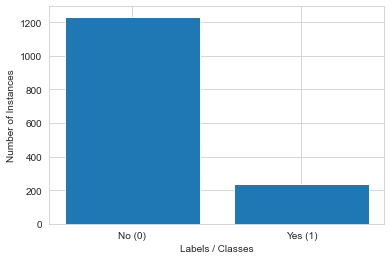

In [14]:
# 条形图
y_bar = np.array([data[data['Attrition']=='No'].shape[0],data[data['Attrition']=='Yes'].shape[0]])
x_bar = ['No (0)', 'Yes (1)']
# Bar Visualization 
plt.bar(x_bar, y_bar)
plt.xlabel('Labels / Classes')
plt.ylabel('Number of Instances')
plt.show()

可以看到，当前流失人数为少部分，大多数员工并未流失。同时也可以看出，流失人数分析属于二分类问题，我们需要使用模型预测出员工是否存在流失情况（是或否）。

查看员工数据所有的特征点：


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

可以发现，数据中包含了共计 35 个特征（包含了 Attrition），其中包括了 9 个 object 类型和 26 个 int64 类型的数据。我们需要对这些数据做归一化处理。
现在计算出每列特征的方差


In [16]:
data.mean()

/var/folders/85/kk7q3wb94jz88s0bdn7qntkw0000gn/T/ipykernel_4057/4080730010.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.mean()


Age                            36.923810
DailyRate                     802.485714
DistanceFromHome                9.192517
Education                       2.912925
EmployeeCount                   1.000000
EmployeeNumber               1024.865306
EnvironmentSatisfaction         2.721769
HourlyRate                     65.891156
JobInvolvement                  2.729932
JobLevel                        2.063946
JobSatisfaction                 2.728571
MonthlyIncome                6502.931293
MonthlyRate                 14313.103401
NumCompaniesWorked              2.693197
PercentSalaryHike              15.209524
PerformanceRating               3.153741
RelationshipSatisfaction        2.712245
StandardHours                  80.000000
StockOptionLevel                0.793878
TotalWorkingYears              11.279592
TrainingTimesLastYear           2.799320
WorkLifeBalance                 2.761224
YearsAtCompany                  7.008163
YearsInCurrentRole              4.229252
YearsSinceLastPr

可以发现，特征中 EmployeeCount 和 StandardHours 的平均值为整，通过查看表数据后发现，两个特征的值相同，对此我们可以移除两个无关联特征。其次特征 Over18 特征值完全相同，所以删去该特征。


In [17]:
data.drop(['StandardHours'], axis=1, inplace=True)
data.drop(['EmployeeCount'], axis=1, inplace=True)
data.drop(['Over18'], axis=1, inplace=True)

在数学中，相关系数可以表示两个连续向量之间的线性关系，两个连续变量中，绘制相关系数的热力图。使用热力图进一步清洗数据，减少不必要的特征，选择关联性更强的特征。

<AxesSubplot:>

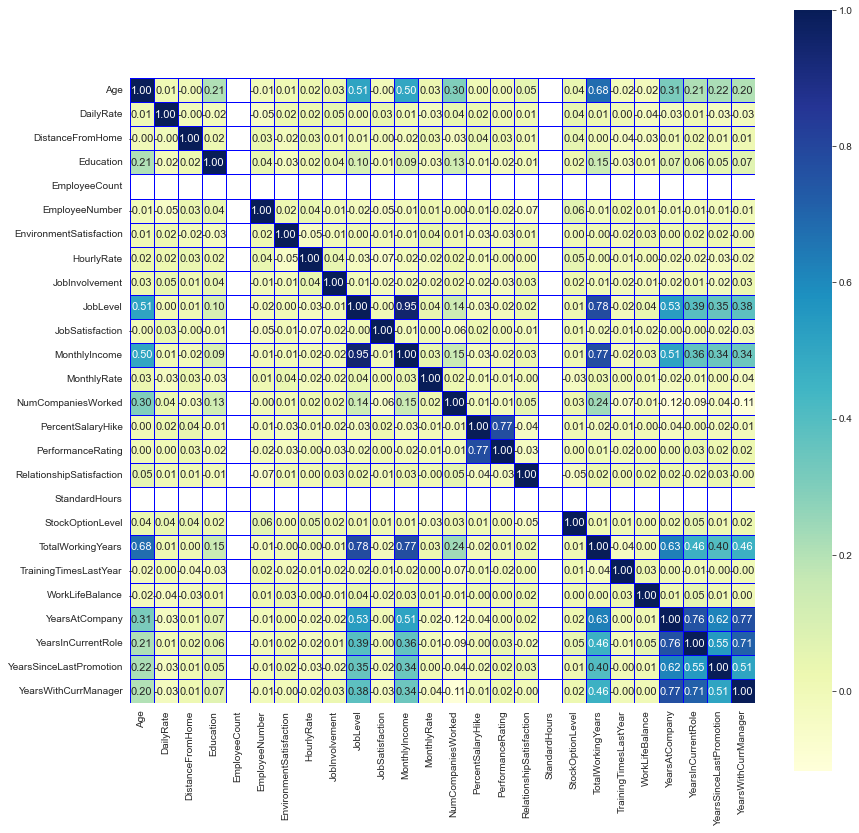

In [18]:
plt.subplots(figsize = (14, 14))
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, cmap="YlGnBu", 
            linewidths=0.5, linecolor='blue')

观察热力图可以发现，图上所示特征中，发现下列相关系数较强组合：
- MonthlyIncome与JobLevel 相关性较强
- TotalWorkingYears与JobLevel相关性较强
- TotalWorkingYears与MonthlyIncome相关性较强
- PercentSalaryHike与PerformanceRating相关性较强
- YearsInCurrentRole与YearsAtCompany相关性较强
- YearsWithCurrManager与YearsAtCompany相关性较强。

总体而言，JobLevel、TotalWorkingYears、YearsInCurrentRole、YearsWithCurrentmanager、PercentSalaryHike有强相关性，故对这些特征进行剔除。

In [19]:
data.drop(['JobLevel','TotalWorkingYears','YearsInCurrentRole', 'YearsWithCurrManager' , 'PercentSalaryHike'], axis=1)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,19479,8,Yes,3,1,0,0,1,6,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,24907,1,No,4,4,1,3,3,10,1
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,2396,6,Yes,3,2,0,3,3,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,23159,1,Yes,3,3,0,3,3,8,3
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,16632,9,No,3,4,1,3,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,...,12290,4,No,3,3,1,3,3,5,0
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,...,21457,4,No,3,1,1,5,3,7,1
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,...,5174,1,Yes,4,2,1,0,3,6,0
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,2065,4,...,13243,2,No,3,4,0,3,2,9,0


下面对数据进行归一化处理。

In [20]:
le = preprocessing.LabelEncoder()
data['BusinessTravel'] = le.fit_transform(data['BusinessTravel'])
data['Department'] = le.fit_transform(data['Department'])
data['Education'] = le.fit_transform(data['Education'])
data['EducationField'] = le.fit_transform(data['EducationField'])
data['JobRole'] = le.fit_transform(data['JobRole'])
data['Gender'] = le.fit_transform(data['Gender'])
data['MaritalStatus'] = le.fit_transform(data['MaritalStatus'])
data['OverTime'] = le.fit_transform(data['OverTime'])
data['Attrition'] = le.fit_transform(data['Attrition'])
print(data)

      Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0      41          1               2       1102           2                 1   
1      49          0               1        279           1                 8   
2      37          1               2       1373           1                 2   
3      33          0               1       1392           1                 3   
4      27          0               2        591           1                 2   
...   ...        ...             ...        ...         ...               ...   
1465   36          0               1        884           1                23   
1466   39          0               2        613           1                 6   
1467   27          0               2        155           1                 4   
1468   49          0               1       1023           2                 2   
1469   34          0               2        628           1                 8   

      Education  EducationF

特征提取与划分，其中划划分测试集数据比例为25%。

In [21]:
X = data.drop(['Attrition'], axis=1)
y = data['Attrition']

# 划分数据
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1753)

## 模型训练

实验中将使用sklearn提供的标准SVC支持向量机模型训练。

In [22]:
# 使用线性核SVC模型训练模型
svc = svm.SVC(kernel='linear', cache_size=1000)
model_svm = svc.fit(x_train,y_train)

In [23]:
# 输出混淆矩阵封装函数
def confusion_custom(test, pred):
    cnf_matrix = metrics.confusion_matrix(test, pred)
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # 输出混淆矩阵图
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # 输出准确度、精确度和召回率
    print("准确率:", metrics.accuracy_score(test, pred))
    # 'micro'：通过计算正确，错误和否定的总数来全局计算指标。
    # 'macro'：计算每个标签的指标，并找到其未加权平均值。这没有考虑标签不平衡。
    print("查准率:", metrics.precision_score(test, pred))
    print("查全率:", metrics.recall_score(test, pred))
    print("F1调和平均值:", metrics.f1_score(test, pred))

准确率: 0.8505434782608695
查准率: 0.625
查全率: 0.1694915254237288
F1调和平均值: 0.26666666666666666


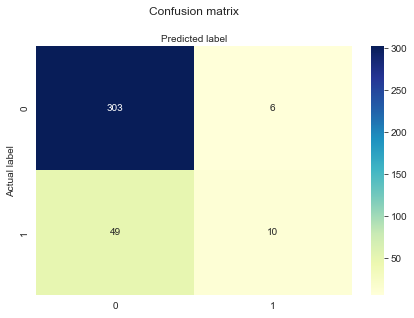

In [24]:
# 混淆矩阵计算
y_pred = model_svm.predict(x_test)
y_score = model_svm.decision_function(x_test)

confusion_custom(y_test, y_pred)

封装P-R、ROC曲线绘制函数

In [25]:
# P-R
def pr_display(test, pred):
    precision, recall, _ = metrics.precision_recall_curve(test, pred)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_display.plot()
    plt.show()

# ROC
def roc_display(test, pred):
    fpr, tpr, _ = metrics.roc_curve(test, pred)
    auc = metrics.roc_auc_score(test, pred)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

绘制P-R曲线和ROC图。

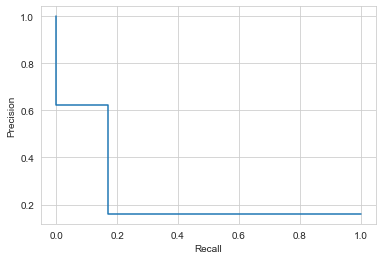

In [26]:
# P-R
pr_display(y_test, y_pred)

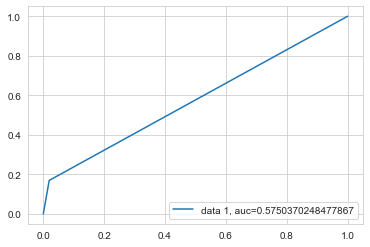

In [27]:
# ROC
roc_display(y_test, y_pred)

输出测试数据和标签的平均精度

In [28]:
print(model_svm.score(x_test, y_test))

0.8505434782608695
